## Overview of Singular Value Decomposition

In this takehome, you will be working on a problem involving singular value decomposition. Singular Value Decomposition (SVD) exists for every rectangular matrix. The nice thing about SVD is that the original matrix can be expressed as the sum of outer products of left and singular vectors scaled by the corresponding singular values. Formally:

> Let 𝛢 be a rectangular matrix of dimensions 𝑚𝘹𝑛, then the SVD of the matrix A is given by $ A = U𝛴V^T$ where $U$ is an orthogonal matrix of shape mxm containing the left singular vectors, $V$ is an orthogonal matrix of shape nxn containing the right singular vectors and $𝛴$ is a diagonal matrix containing the singular values of $A$. This formulation of SVD can be re-expressed as \begin{align} A = \sum_{i=1}^{r} s_i. u_i v_i^T \end{align} where $r = \text{min}(m,n)$ represents the rank of the matrix, $s_i$ is the $i$th singular value and $u_i v_i^T$ is the outer product of the $i$th left and right singular vectors. 

<!-- \begin{align}
A = \sum_{i=1}^{\text{min}(m,n)} s_i. u_i v_i^T
\end{align}
\begin{align} -->

> The singular values $𝛴$ are decreasing in order. So, each outer product is scaled by a smaller value as we compute each term in the sum above. This gives us an opportunity to approximate $A$ using only the sum of the first $k$ outer products where $k < \text{min}(m,n)$ $-$ this effectively means that we are zero-ing out some of the singular values by assuming that the contribution to the sum is negligible. This is called low-rank approximation.

If you aren't familiar with singular value decomposition, or the above feels rusty, don't worry. Take a moment to brush up your knowledge using any of the following resources:
* [stanford lecture notes on low rank approximations](https://web.stanford.edu/class/cs168/l/l9.pdf)
* [youtube series of short and beginner friendly lectures](https://www.youtube.com/watch?v=gXbThCXjZFM&list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv)



## Check for understanding (3 points)

#### Q1: What are some real world applications of low rank approximations?


#### Answer:

1. It can be used for **compression** (meaning, we use only few components that contain the most of the information e.g. compressing an image to use less storage). 
2. Low rank approximation can be use for **de-noising** as the very understanding of noise is that it should not be the definitive part of the information and so it should live in low importance components we chop off (e.g. removing licence plates to prepare images for some DL model). 
3. A third application of low rank approximations would be **matrix completion** when our row-wise and column-wise correlated matrix is sparse and we want to fill gaps for some similarity based applications (e.g. large matrices for recomender systems seem to be most beloved example of this).


#### Q2: What are the benefits of compressing a deep neural network? How would you measure the benefits of compression?


#### Answer: 
####A. Benefits of compresing DL model may be following: 

1. we may want to satisfy some resource constraint like less memory usage/ power consumption/ network communication bandwidth. 
2. we may reduce latency as well

main goal is optimal choice between accuracy, latency and resourse requirements tailored for a given case. 

####B. Measurement of the benefits of compression (written in general form, can be rewritten in layer number dependent way):

1. **Speed up:** from the $min(O(n^2m), O(m^2n))$  to the $O(nmk)$ because k is significantly smaller than given n or m
2. **Storage needed:**  from the $O(nm)$ to the $O(k(n+m))$

of course $(A − A_k)_F ≤ (A − B)_F$ where $B$ is rank $k$ and $k>=1$

#### Q3: In this takehome, we will consider how singular value decomposition can be used to compress a deep neural network. Compared to other compression methods used for deep neural networks such as pruning, quantization, or efficient architectures, what are the relative merits/demerits of low rank approximations? Choose one or two alternative compression methods and compare with singular value decomposition.

#### Answer: 

This question allows to go very fahr/deep in the literature and in choosing the comparison criteria. Here I try to focus only on just a general notion of needed space (without specifying for GPU, CPU, TPU etc.), on general notion of latency (inference mainly) on methods generaly (not on their diverse types) on example of ConvNets.

1. Among **pruning, quantization, low rank approximation**, the latest is most prone to **accuracy drop with increasing compression rate**, while there is no clear winner between pruning, quantization. In some architectures prunning winns (e.g. vgg) in others quantization performes better (e.g. ResNet). [Here](https://faculty.ucmerced.edu/mcarreira-perpinan/papers/ijcnn21c.pdf) and [here](https://arxiv.org/pdf/2101.09671.pdf) are actual comparisons under comparable settings for nn performance of different compressed architectures. 
2. On the other hand **prunning** requires much longer training time (needs several iterations between prunning and retraining/or tunning) and 
3. **quantization** can be extremely trickty to actually implement (as an optimal implementation can be extremely hardware dependent and also quantization of just pretrained weights is not all we want - we want quantization of operators as well and unseen inputs and potential bit overflows may be a problem). 
P.S. this [blog](https://medium.com/gsi-technology/an-overview-of-model-compression-techniques-for-deep-learning-in-space-3fd8d4ce84e5) helped a lot in the beginning.



---



### Imports

In [ ]:
!pip install -q dm-haiku optax

     |████████████████████████████████| 350 kB 18.6 MB/s 
     |████████████████████████████████| 145 kB 46.5 MB/s 
     |████████████████████████████████| 85 kB 2.6 MB/s 


In [ ]:
from typing import Iterator, Mapping, Tuple
from copy import deepcopy
import time
from absl import app
import haiku as hk
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np
import optax
import tensorflow_datasets as tfds
import tensorflow as tf
from functools import partial
import math

Batch = Tuple[np.ndarray, np.ndarray]



---




## Coding Challenge Part I : Debugging Challenge (10 Points)


We are now going to explore using SVD to compute low rank approximations of the parameters of a small deep neural network. You are using a very simple toy model as a first baseline. Section 3 will give you the chance to improve baseline accuracy beyond this very simple model -- this is just a toy setting to first explore low rank approximations.

The first part of this challenge is primarily a debugging challenge. It will require removing bugs in order to train a very simple network. We have introduced several bugs -- some are subtle and will not break your code but will degrade final performance. These subtle bugs are introduced to understand your grasp of fundamental machine learning principles. There are also more obvious bugs designed to break your code. 

* [**4 points**] Your goal is to get the code working. There are 4 bugs in the code, these are subtle bugs which are designed to impair test accuracy but not break the code. You will get partial points for each of the 4 bugs you find. After finding all bugs, your test performance should be around 66-67% test accuracy.

* [**2 points**] We will give extra points for also adding improved documentation to each of the functions we introduce in this section, and for describing the fixes to the bugs. 

* [**4 points**] There are also two functions you will need to code up in this section -- we indicate where these code changes need to happen with TODO comments. 

* Do not alter the model architecture or the learning rate.

In [ ]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)


def net_fn(batch: Batch) -> jnp.ndarray:
  """ MLP network based on haiku sequential list of layers 
      for 10 class based image classification 
      Input: batch of type batch/tuple with 2 numpy.ndarray elements,
             Tuple[np.ndarray, np.ndarray] :
             batch[0] is (64, 32, 32, 3) numpy.ndarray 
                          where 64 is batch size and can be any size
                          32,32,3 corresponds to image dimensions
             batch[1] is (64,) numpy.ndarray:
                          is array of labels 0 to 9, corresponding to 10 classes
      Output:
             10 prediction values for each class """
  x = normalize(batch[0])  
  
  # Do NOT alter the architecture definition below.
  net = hk.Sequential([
      hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      hk.Flatten(),
      hk.Linear(3000), jax.nn.relu,
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(1000), jax.nn.relu,
      hk.Linear(10),
  ])
  return net(x)

def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
) -> Iterator[tuple]:
  """Loads the dataset as a generator of batches.
     Input: 1. split: part of dataset that we want to load should be used like python string slicing
               Optional[Tree[splits_lib.SplitArg]] = None,
            2. * : placeholder for args
            3. is_training: type of bool, if True it shuffles data randomly each time batch is called
            4. batch_size: type of integer, defines how many `picture` label pairs are processed in a 
               single forward pass. treated as tfds.typing.Dim 
      Output: Iterable over two element tuples Tuple[np.ndarray, np.ndarray]
              consisting of:
              batch[0] is (64, 32, 32, 3) numpy.ndarray 
                  where 64 is batch size and can be any size
                  32,32,3 corresponds to image dimensions
             batch[1] is (64,) numpy.ndarray:
                  is array of labels 0 to 9, corresponding to 10 classes"""
  ds = tfds.load('cifar10', split=split, as_supervised=True).cache().repeat()
  if is_training:
    # changed this: 10 * batch_size, to whole dataset size not to add bias for different sizes of tested batches, just to be on safe side. 10 * batch_size,
    # and jes, I am not spliting training data into train/val
    ds = ds.shuffle(50000, seed=0) 
  ds = ds.batch(batch_size)
  return iter(tfds.as_numpy(ds))

@jax.jit
def compute_loss(params: hk.Params, batch: Batch) -> jnp.ndarray:
  """Computes the loss of the network with L2 norm penalty.
     Input: 1. params: parameters of the MLP having type of haiku.Params
            2. batch: having type of batch/two element tuple
                      Tuple[np.ndarray, np.ndarray]:
                      batch[0] is (64, 32, 32, 3) numpy.ndarray 
                          where 64 is batch size and can be any size
                          32,32,3 corresponds to image dimensions
                      batch[1] is (64,) numpy.ndarray:
                          is array of labels 0 to 9, corresponding to 10 classes
      Output: cross-entropy loss with regularization penalty, type of float""" 
  x, y = batch
  logits = net.apply(params, batch)
  labels = jax.nn.one_hot(y, 10)

  # TODO: add code below to compute the l2_loss variable
  
  ### here jax.tree_util.tree_leaves(params) gives list of weight and bias parameters from the model 'params'
  ### every second starting from 0 is a bias and every second starting from 1 is a weight. we take those weights,
  ### we square them, we sum up results as a L2_loss
  ### at first I thought task was actual l2 not its specific understanding as Frobenius for regularization: l2_loss = jnp.sum((labels - logits)**2) where it appeares optax.l2_loss() can be also used                 
  ### I am still not shure if the L2 regularization of Ws is meant here - everything looks like it should mean it.
  ### l2_loss = sum([jnp.sum(w**2) for i, w in enumerate(jax.tree_util.tree_leaves(params)) if i/2!=0]) 
  ### as biases are scallars I ommit them though we can include them in l2_loss = sum([jnp.sum(w**2) for w in jax.tree_util.tree_leaves(params)]) 
  ### jnp.sum(jnp.vdot(w, w) or jnp.sum(w**2.0) # leaves, _ = jax.tree_util.tree_flatten(params) or jax.tree_util.tree_leaves(params)
  l2_loss = sum([jnp.sum( jnp.vdot(w, w)) for i, w in enumerate(jax.tree_util.tree_leaves(params)) if i/2!=0])    
  
  weighted_l2_loss =  0.5 * l2_loss                        

  ## not a subtle bug, it appeares: jax.nn.log_softmax(a)==jax.nn.log_softmax(a, axis=1) # still added axis=1 to be on safe side
  ## I changed jax.nn.log_softmax to optax.sigmoid_binary_cross_entropy juat to use (0s) false minimization as well with true maximization for the learning
  ## softmax_xent = jnp.sum( optax.sigmoid_binary_cross_entropy(logits, labels)) it worked better! but in case I'm not allowed to do so I go back to original one
  
  ### here we use softmax with sum reduction for calculating crossentropy, but jnp.mean() instead of jnp.sum() gave more stable results and +2% accuracy
  ### So, I mimiced mean reduction by applying: softmax_xent /= y.shape[0] but with some learning rates just sum reduction works better
  ### besides binary cross entropy we could use multinomial logistic regression for multiple classes 
  
  softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits, axis=1))
  ### softmax_xent /= y.shape[0]

  ### I deliberately did not use averaging softmax_xent /= y.shape[0]
  ### I focused more on increase of test accuracy little bit on expance of train accuracy as well, that's one reason for not using: softmax_xent /= y.shape[0]
  
      ### ### two subtle bugs in -->  softmax_xent - (1e-4 * l2_loss) : ### ###

  ### subtle bug 1:
  ### 1. here should be addition, not softmax_xent - (1e-4 * l2_loss) becausse we want to accumulate losses to forse nn make both losses smaller
  ### starting accuracy was 10%. 
  ### Fixing this bug increased test and validation accuracy at least by 20% 
  
  ### subtle bug 2:
  ### 2. there was l2_loss standing in place of weighted_l2_loss. So I replaced it.  
  ### (Than I made mistake as according to the math formula weighted_l2_loss should be devided over 2m and m in this case is batch size: 
  ### batch[0].shape[0] if I would use optax.sigmoid_binary_cross_entropy then it would be batch[0].shape[0]*10 )
  ### I added division over 2m ((1 / (2*batch[0].shape[0]*10) ) * weighted_l2_loss) 
  ### but than I realized that division by m is done afterwards in with backward process and division by 2 we have already done by 0.5*L2_loss. So, removed it.
  ### second bug fix caused increase in accuracy (test-with average params, valid-with params) by around 3-4%

  ### First I thought lambda=1e-4 was subtle bug 3 --> but it is not! 
  ### I am leaving though what I went through as suggested at the introductory introductory meeting:

      ### got Train / Validation / Test accuracy: 0.992 / 0.543 / 0.531 with lambda=1e-4 -->obviously diversity gap is large and regularization 
      ### Should help as it is exactly designed for addressing overfitting problem. I already moved as much data as possible to train set. 
      ### as this is bug fixing homework I do not apply other possible methods like augmentation, dropout, weight clipping etc or bach normalization,  
      ### and I will only try to tune Lambda between zero and 10 on the log scale (not to be biased) or later will further cross validate it.
      ### I am looking at: 
        # 1.how fast training accuracy diverges from valid accuracy and how fahr - as ideally if train acc becomes as big as our wanted 67% val_acc/test_acc will be adjusted 
        # 2. bigger batch size to some point allows us to be more aggressive and that point is untill training accuracy does not get to bad(e.g.<67%) or to good(>80)
        # 3. I am stopping early when I see any type of big fluctuations or too mutch inconsistent pick up of values between train and validation accuracies (test mirrors validation later)
        # 4. how fast is transition of accuracy from 10s to 20s to 30s  etc. 
      ### Lambda= (13.6 * 1e-2) or (11.6 * 1e-2 ) instead Lambda= 1e-4 boosted test accuracy to 61.1 % (by 8%) 
      ### todo: if time left go through literature to find better methods for adjusting lambda (there are some, even kernel dependents) 
      ### here is still a lot of room for improvement
      ### If somewhere else is the bug: 
      ### If overfitting can not be solved by our single tool - regularization, so the bug may be somewhere in data retreival (dataloader?) or in access of data:
      ### (cache? reshaffling? randomseed?). And Yes, this direction for bug search was right. Several Bugs are in normalize function.

  #### we could just:
  ####  logits = net.apply(params, batch)
  ####  labels = jax.nn.one_hot(batch[1], 10)
  ####  l2_loss = 0.5 * sum(jnp.sum(jnp.square(parameter)) for parameter in jax.tree_util.tree_leaves(params))
  ####  softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
  ####  softmax_xent /= labels.shape[0]
  
  return softmax_xent + (11.6 * 1e-2 * weighted_l2_loss)  

@jax.jit
def compute_accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
  """Computes the accuracy of MLP predictions as a fraction of correct guesses over all predictions.
     Input: 1. params: parameters of the MLP having type of haiku.Params.
            2. batch: having type of batch/two element tuple
                      Tuple[np.ndarray, np.ndarray]:
                      batch[0] is (64, 32, 32, 3) numpy.ndarray 
                          where 64 is batch size and can be any size
                          32,32,3 corresponds to image dimensions
                      batch[1] is (64,) numpy.ndarray:
                          is array of labels 0 to 9, corresponding to 10 classes
      Output: type of float accuracy describing fraction of correct guesses over all predictions""" 

  predictions = net.apply(params, batch)

  # TODO: add code below to compute the accuracy over the batch.

  ### line 1: we take labels from each memeber of the tuple batch (`img`, `label`), where labels are integers 0-9
  ### line 2: in predictions each row is dedicated to one single image prediction with 10 different scores, where place of score
  ### describes the class 0-9th position and score describes how much confident is the model, so we need place of highest score across the row
  ### which we retrieve with jnp.argmax(). So we have models prediction in form of class 0-9 and we check if this one corresponds with the given label ('==') 
  ### to get right guesses as Trues and incorrect guesses as Falses
  ### line 3: As right guesses are True and incorrect ones are False, they correspond to 1s and 0s. 
  ### So, we count nonzeros and devide them by length of all labels to get the portion of right guesses among all guesses.
  _, lables = batch
  right_guesses = jnp.argmax(predictions, axis=1)==lables 
  accuracy = jnp.count_nonzero(right_guesses) / len(lables)
  return accuracy                                          ## or just jnp.mean(jnp.argmax(predictions, axis=-1) == lables)

@jax.jit
def update(
    params: hk.Params,
    opt_state: optax.OptState,
    batch: Batch,
) -> Tuple[hk.Params, optax.OptState]:
  """Defines the learning rule (the stochastic gradient descent).
     Input: 1. params: parameters of the MLP having type of haiku.Params.
            2. opt_state: having type of optax.OptState contains an optimizer state 
                          that is used to calculate parameter updates from their gradients.
            3. batch: having type of batch/ two element tuple
                      Tuple[np.ndarray, np.ndarray]:
                      batch[0] is (64, 32, 32, 3) numpy.ndarray 
                          where 64 is batch size and can be any size
                          32,32,3 corresponds to image dimensions
                      batch[1] is (64,) numpy.ndarray:
                          is array of labels 0 to 9, corresponding to 10 classes
      Output: updated parameters and current optimizer state """ 
  grads = jax.grad(compute_loss)(params, batch)
  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(params, updates)
  return new_params, opt_state

@jax.jit
def ema_update(params, avg_params):
  """Polyak exponential moving average calculation 
     based on previous exp moving average and new parameter state
     used only for evaluation, not for learning.
     Input: 
          1. params: new updated parameters of the MLP, having type of haiku.Params.
          2. avg_params: exponential moving average of all previous states of MLP parameters,
                         having type of haiku.Params.
      Output: new exponential moving average considering current parameter state"""
  return optax.incremental_update(params, avg_params, step_size=0.001) #polyak

#### subtle bugs 3 and 4 (probably 5 as well and bug 6 comes in the next cell):
#### subtle bug 3:
#### conversion of whole batch to jnp.int8 even before applying mean&std alters images, as cyfar10 images, according to tensorflow docs are datatype tf.uint8
#### so, images have type on which the mean and std is calculated and by using additional unnecessary conversion even before applying 
#### the normalization or standartization we are very much altering the data. I found this bug only after the bug 4 (+5) that comes next. 
#### I changed order just because of (+5) bug is associated with bug 4 and I did not want to have "unreal bug 5" between real bugs (real bug 6 comes in next cell)
#### I got accuracy boost to 70% after fixing this bug [Step 10000] Train / Validation / Test accuracy: 0.844 / 0.734 / 0.703.

#### subptle bug 4 (and 5):
#### here we had x /- mean instead of x-=mean, which was incorrect, as we want to substract mean from x and so we have to do it as follows: x-=mean
#### this is because we do per-dataset / feature-wise standartization, 
#### but when we do it with entire datasets mean&std on the whole batch vs single image results are different! (I do Not mean per-image/sample-wise)
#### So, something else is wrong here as well
#### Yes, it appeares application of  normalization and standartization (even int8 type) applied to a single image gives very different result 
#### from when applied on batch. Fixing this 4 (+5) bug caused very minor increase in accuracy, around 4%

def normalize(images):
  """ Function applies pixel Normalization and 
      pixel standartization with pixel Centering to the input.
      Input:  np.ndarray corresponding to the batch of `images`, 
              having tyoe of Tuple[np.ndarray, np.ndarray]:
              batch[0] is (64, 32, 32, 3) numpy.ndarray 
              where 64 is batch size and can be any size
              32,32,3 corresponds to image dimensions
      Output: normalized and standartized ndarray of same shape (64, 32, 32, 3)""" 

  mean = np.asarray(CIFAR10_MEAN)
  std = np.asarray(CIFAR10_STD)
  # ## 'Pixel' Normalization
  # x = images.astype(jnp.int8) / 255.
  # ## 'Pixel' standartization that includes 'Pixel' Centering    
  # x -= mean
  # x /= std 
  # x = images.astype(jnp.int8)  
  # ## this part with a for iterator does not work as jax is tracking x and conflicts with np.asarray(x, dtype=np.float64) converting it to 
  # ## jax array causes another problem
  # x = [((x.astype(jnp.int8)/225.)-mean)/std for x in images]  
  # x = np.asarray(x, dtype=np.float64)  #or np.array(x).astype(np.float64)  
  # ## with jnp.int8 we get rough contures of the shape, the information about the object is altered 
  # convert = lambda z: ((z.astype(jnp.int8)/225.)-mean)/std               
  # x = convert(images)
  convert = lambda z: ((z/225.)-mean)/std               
  x = convert(images)

  return x

## test:
# validation = load_dataset("test[0%:50%]", is_training=False, batch_size=64) 
# batch=next(validation)
# mean = np.asarray(CIFAR10_MEAN)
# std = np.asarray(CIFAR10_STD)
# plt.imshow(((batch[0][11].astype(jnp.int8)/225.)-mean)/std)
#plt.imshow(normalize(batch[0][11]))
#plt.imshow(batch[0][11])

### Training

In [ ]:
net = hk.without_apply_rng(hk.transform(net_fn)) 

# Do not change learning rate
opt = optax.adam(1e-3)

### subtle bug 5 or 6:
### trn = train[80%:] , val= train[0%:80%] splits were not focusing on having as much training samples as possible 
### because validset would get 80% and trainset would get 20% of the splited data. Here I put all 50000 images in training set and split testset into val&test
### boosted accuracy by around 16%

### for small data, espetially when we have so many training steps big batch may cause little overfitting + I had to make batch sizes smaller for fast testing 
### & just made batch sizes more in correspondence to info retrival exponents of 2 (RAM or 256 bit M4000 GPU) 
### boosted accuracy by around 4% (assuming more granular orthogonalization is not needed)

train = load_dataset("train", is_training=True, batch_size=64)                  # smalest batch size with least fluctuation was 128     
validation = load_dataset("test[0%:50%]", is_training=False, batch_size=64) 
test = load_dataset("test[50%:]", is_training=False, batch_size=5000)         


params = avg_params = net.init(jax.random.PRNGKey(42), next(train))       
opt_state = opt.init(params) 

for step in range(10001): 
  if step % 100 == 0:   #1000 changed with 100 just to see more often what is happening
    #### added this just to keep track on difference between test and validation to see what is the bias
    train_accuracy = compute_accuracy(params, next(train))
    #### changed here avg_params to params to make it comparable with train_accuracy for diversity check
    val_accuracy = compute_accuracy(params, next(validation))
    test_accuracy = compute_accuracy(avg_params, next(test))  #### data mismatch is not expected, if there will be any gaps probably because of exponential moving averages step being not in compliance with used steps and curve was shifted to the right. So, first check that.
    train_accuracy, val_accuracy, test_accuracy = jax.device_get(
        (train_accuracy, val_accuracy, test_accuracy))
    print(f"[Step {step}] Train / Validation / Test accuracy: "
          f"{train_accuracy:.3f} / {val_accuracy:.3f} / {test_accuracy:.3f}.")

  params, opt_state = update(params, opt_state, next(train))
  avg_params = ema_update(params, avg_params)

### [Step 10000] Train / Validation / Test accuracy: 0.844 / 0.734 / 0.703. is achieved result

/usr/local/lib/python3.7/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


[Step 0] Train / Validation / Test accuracy: 0.094 / 0.094 / 0.103.
[Step 100] Train / Validation / Test accuracy: 0.156 / 0.297 / 0.171.
[Step 200] Train / Validation / Test accuracy: 0.234 / 0.172 / 0.171.
[Step 300] Train / Validation / Test accuracy: 0.250 / 0.312 / 0.191.
[Step 400] Train / Validation / Test accuracy: 0.266 / 0.328 / 0.209.
[Step 500] Train / Validation / Test accuracy: 0.250 / 0.344 / 0.230.
[Step 600] Train / Validation / Test accuracy: 0.516 / 0.438 / 0.248.
[Step 700] Train / Validation / Test accuracy: 0.312 / 0.484 / 0.270.
[Step 800] Train / Validation / Test accuracy: 0.578 / 0.469 / 0.286.
[Step 900] Train / Validation / Test accuracy: 0.406 / 0.438 / 0.300.
[Step 1000] Train / Validation / Test accuracy: 0.516 / 0.516 / 0.319.
[Step 1100] Train / Validation / Test accuracy: 0.531 / 0.453 / 0.337.
[Step 1200] Train / Validation / Test accuracy: 0.531 / 0.516 / 0.359.
[Step 1300] Train / Validation / Test accuracy: 0.516 / 0.500 / 0.378.
[Step 1400] Train 

## Coding Challenge Part 2: Compression through Low Rank Approximation (8 points)

In this section, you will add code to compute the low rank approximation and to compute evaluation metrics. We will evaluate whether the low rank approximation allows for speed up in inference time. We define inference time as the average time to compute the prediction for all examples in the test set.

* [**4 points**] You will need to add code to define both the compute_eval_metrics and rank_approximated weight function. 
* [**4 points**] Q4 and Q5 are worth 2 points each.

In [ ]:
def compute_eval_metrics(params, batch, n_samples):
# TODO: add code to compute the time for inference.
  duration_list = []
  accuracy_list = []

  #took some guidance from pytorch, but not everything applies: https://deci.ai/blog/measure-inference-time-deep-neural-networks/
  # I assume that  "warm_up" like concept in some form applies to jax as well as JIT compilation should affect inference time
  # So, to be on safe side I adopt this concept from pytorch example
  # I still have to look if there are torch like concepts about gradient tracing (like e.g. torch.no_grad()) and automatic diff
  for _ in range(10):
    warm_up = compute_accuracy(params, batch).block_until_ready()

  for _ in range(n_samples):
    # generally timeit() seems to be better choice if our result should be purified from garmadge collecction processes as well
    # https://docs.python.org/3/library/timeit.html#timeit.Timer.timeit and https://stackoverflow.com/questions/70161804/python-time-difference-jax-library
    # I use time.time() or time.process_time() as we have time imported above
    start = time.time()  

    # TODO: add code to correctly compute the accuracy on a given batch.

    # used block_until_ready() for correct measurements with asinchronous execution https://jax.readthedocs.io/en/latest/async_dispatch.html
    acc = compute_accuracy(params, batch).block_until_ready() 
      #### I should not do this here, because it appeares tehre are other excercises in following sections dedicated to this:
      #### divided on batch[0].shape[0] because it is batch size and we get average time for individual predictions, but this can be ommited
      #### duration = (time.time() - start) / batch[0].shape[0]  
      #### but it would be easier to do this here and would need less code        
    duration = (time.time() - start)    # or time.process_time() - start
    duration_list.append(duration)
    accuracy_list.append(acc)

  return accuracy_list, duration_list

## test:
# accuracy_list, duration_list = compute_eval_metrics(params, next(test), 5) 
# accuracy_list, duration_list

In [ ]:
def rank_approximated_weight(weight: jnp.ndarray, rank_fraction: float):
  # TODO: replace the code below with code to compute the SVD of the matrix to return the rank approximated weights u and v for a given matrix.
  # u = jax.random.normal(jax.random.PRNGKey(42), shape=weight.shape)
  # size = weight.shape[1]
  # v = jax.random.normal(jax.random.PRNGKey(42), shape=(size,size))

  #full_matrices=True is default but we want economy svd
  u, s, v = jnp.linalg.svd(weight, full_matrices=False)   #np.linalg.svd(weight, full_matrices=False) 
  rank_fraction = int(rank_fraction // 1)   #here I just take integer because function indicates that for some reason it gets float, maybe I see later why
  u, v = u[:, :rank_fraction], s[:rank_fraction].reshape(-1, 1) * v[:rank_fraction, :]

  return jnp.array(u, dtype=weight.dtype), np.array(v, dtype=weight.dtype) #np.array(u, dtype=weight.dtype), np.array(v, dtype=weight.dtype)

# weight = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
# u, s, v = np.linalg.svd(weight, full_matrices=True)       
# u.shape, s.shape, v.shape
# s_diagonal = np.diag(s)
# s_diagonal
# sigma = np.zeros((s_diagonal.shape[0], v.shape[0]))
# sigma
# difference = v.shape[0] - s_diagonal.shape[0]
# difference
# if difference>0: 
#   sigma[:, :-difference] = s_diagonal
# else: sigma = s_diagonal
# sigma
# np.array((np.dot(np.dot(u, sigma), v)), dtype=weight.dtype) == weight
# u[:, :2], v[:2, :]

# ## test:
# U, V = rank_approximated_weight(weight, 1.5)
# ## np.array(U, dtype=weight.dtype) == np.array(u[:, :1], dtype=weight.dtype), np.array(V, dtype=weight.dtype) == np.array(v[:1, :], dtype=weight.dtype)
# U == np.array(u[:, :1], dtype=weight.dtype), V == np.array(v[:1, :], dtype=weight.dtype)


### Evaluations at different ranks

The code below first replaces the weights with the low rank factorizations at different rank fractions. For each modified net, we compute the new eval accuracy. Firstly, add code for the rank_approximated_weight and add code to correctly compute the time for inference (the duration).

In [ ]:
rank_truncated_params = deepcopy(params)
ranks_and_accuracies = []
ranks_and_times = []
for rank_fraction in np.arange(1.0, 0.0, -0.1):

  print(f"Evaluating the model at {rank_fraction:.2f}")
  for layer in params.keys():
    if 'conv' in layer:
      continue
    weight = params[layer]['w']
    # TODO: complete coding the rank_approximated_weight function to compute 
    # the SVD of the matrix to return the rank approximated weights u and v for a given matrix.
    u, v = rank_approximated_weight(weight, rank_fraction*weight.shape[1])
    rank_truncated_params[layer]['w'] = u@v

  test_batch = next(test)
  # we compute metrics over 50 samples to reduce noise in the measurement.
  n_samples = 50

  # TODO: complete coding the compute_eval_metrics function to compute the time taken for inference.
  
  ### If I have understood it correctly model inference time is defined as: 
  ### "the average time to compute the prediction for all examples in the test set" 
  ### which probably means all_time/(batch_size*number_of_batches)
  ### here this would mean all_time/(test_batch*n_samples)  but we do later np.mean(latency) which ommits x/y*n_samples and we have only x/y
  ### So, at this stage we have to devide every member of latencies over batch size
  # note for myself! if you want that batch reshaffles each time put here directly next(test) not test_batch, where you have to mind possibility of small last batches
  test_accuracy, latency = compute_eval_metrics(rank_truncated_params, next(test), n_samples)
  latency = [(i/test_batch[0].shape[0]) for i in latency]

  print(f"Rank Fraction / Test accuracy: "
          f"{rank_fraction:.2f} / {np.mean(test_accuracy):.3f}.")
  ranks_and_accuracies.append((rank_fraction, np.mean(test_accuracy)))
  print(f"Rank Fraction / Duration: "
          f"{rank_fraction:.2f} / {np.mean(latency):.12f}.")
  ranks_and_times.append((rank_fraction, np.mean(latency)))

## compare:
# accur, lat = compute_eval_metrics(params, test_batch, n_samples)
# print(np.mean(accur), np.mean(lat)) 
# print(compute_accuracy(params, next(test)))

Evaluating the model at 1.00
Rank Fraction / Test accuracy: 1.00 / 0.669.
Rank Fraction / Duration: 1.00 / 0.000024320766.
Evaluating the model at 0.90
Rank Fraction / Test accuracy: 0.90 / 0.668.
Rank Fraction / Duration: 0.90 / 0.000024385331.
Evaluating the model at 0.80
Rank Fraction / Test accuracy: 0.80 / 0.662.
Rank Fraction / Duration: 0.80 / 0.000024256930.
Evaluating the model at 0.70
Rank Fraction / Test accuracy: 0.70 / 0.666.
Rank Fraction / Duration: 0.70 / 0.000024371918.
Evaluating the model at 0.60
Rank Fraction / Test accuracy: 0.60 / 0.662.
Rank Fraction / Duration: 0.60 / 0.000024382053.
Evaluating the model at 0.50
Rank Fraction / Test accuracy: 0.50 / 0.664.
Rank Fraction / Duration: 0.50 / 0.000024374065.
Evaluating the model at 0.40
Rank Fraction / Test accuracy: 0.40 / 0.614.
Rank Fraction / Duration: 0.40 / 0.000024386460.
Evaluating the model at 0.30
Rank Fraction / Test accuracy: 0.30 / 0.550.
Rank Fraction / Duration: 0.30 / 0.000024360138.
Evaluating the m

### Q4: What do you observe as the relationship between rank fraction and test accuracy?

Plot this relationship showing accuracy (y-axis) vs rank percentage of the matrix (x-axis). You should use the ranks_and_accuracies list computed above.

Answer:

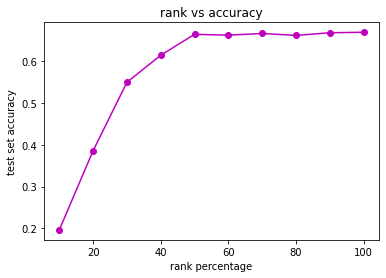

In [ ]:
## TODO: add your code below to plot the relationship between time and test set accuracy
######## !!! please note, this TODO does not correspond to Q4 task, I am following the Q4 task description as it seems to be more useful
times = [t for _, t in ranks_and_times]
accuracies = [acc for _, acc in ranks_and_accuracies]
rank_percentage = np.arange(1.0, 0.0, -0.1)*100

plt.title('rank vs accuracy')
plt.xlabel("rank percentage")
plt.ylabel("test set accuracy")

plt.plot(rank_percentage, accuracies, 'mo-');


### Q5: Does replacing the weight matrix with the low factor matrix result in latency speed ups?

Plot the relationship of time (y-axis) vs rank percentage (x-axis). To do so add code to compute the ranks_and_times list.

Answer:

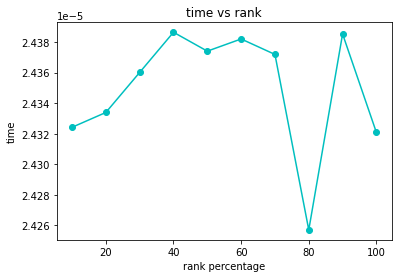

In [ ]:
## TODO: add your code below to plot the relationship between time and rank percentage
plt.title('time vs rank')
plt.xlabel("rank percentage" )
plt.ylabel("time")

plt.plot(rank_percentage, times, 'co-');

## Coding Challenge Part 3: Perform evaluations on the dataset in factorized space. (4 points)

In this section, you will perform evaluations on the dataset in factorized space.

* [**4 points**] 2 pts for question 6 and question 7.

In [ ]:
def low_rank_net_fn(batch: Batch, rank: float) -> jnp.ndarray:
  
  x = normalize(batch[0])
  total_input_dim = np.prod(x.shape[1:])

  # Do not alter the architecture code.
  net = hk.Sequential([
      hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      hk.Flatten(),
      hk.Linear(int(rank * min(total_input_dim, 3000)), with_bias=False),
      hk.Linear(3000), jax.nn.relu,
      hk.Linear(int(rank * 2000), with_bias=False), 
      hk.Linear(2000), jax.nn.relu,
      hk.Linear(int(rank * 2000), with_bias=False), 
      hk.Linear(2000), jax.nn.relu,      
      hk.Linear(int(rank * 1000), with_bias=False), 
      hk.Linear(1000), jax.nn.relu,
      hk.Linear(int(rank * 10), with_bias=False),
      hk.Linear(10),
  ])
  return net(x)

In [ ]:
vanilla_to_low_rank_map = {
    'conv2_d': 'conv2_d',
    'conv2_d_1': 'conv2_d_1',
    'linear': ['linear', 'linear_1'],
    'linear_1': ['linear_2', 'linear_3'],
    'linear_2': ['linear_4', 'linear_5'],
    'linear_3': ['linear_6', 'linear_7'],
    'linear_4': ['linear_8', 'linear_9']
}


ranks_and_accuracies = []
ranks_and_times = []
for rank_fraction in np.arange(1.0, 0.0, -0.1):
  low_rank_net_fn_partial = partial(low_rank_net_fn, rank=rank_fraction)
  net = hk.without_apply_rng(hk.transform(low_rank_net_fn_partial)) 
  low_rank_params = net.init(jax.random.PRNGKey(42), next(train))

  print(f"Evaluating the model at " f"{rank_fraction:.2f}")

  for layer in vanilla_to_low_rank_map.keys():
    if 'conv' in layer:
      low_rank_params[layer] = params[layer]
      continue
    weight = params[layer]['w']
    # TODO: complete coding the rank_approximated_weight function to compute the SVD of the matrix to return the rank approximated weights u and v for a given matrix.
    u, v = rank_approximated_weight(weight, rank_fraction*weight.shape[1])
    low_rank_params[vanilla_to_low_rank_map[layer][0]]['w'] = u
    low_rank_params[vanilla_to_low_rank_map[layer][1]]['w'] = v
    low_rank_params[vanilla_to_low_rank_map[layer][1]]['b'] = params[layer]['b']
  
  # TODO: modify the compute_eval_metrics function below to compute the time taken for inference.
  batch = next(test)
  test_accuracy, duration = compute_eval_metrics(low_rank_params, next(test), 50)
  duration = [(i/batch[0].shape[0]) for i in duration]

  ranks_and_times.append((rank_fraction, np.mean(duration)))
  ranks_and_accuracies.append((rank_fraction, np.mean(test_accuracy)))
  print(f"Rank Fraction / Test accuracy: "
          f"{rank_fraction:.2f} / {np.mean(test_accuracy):.3f}.")
  print(f"Rank Fraction / Duration: "
          f"{rank_fraction:.2f} / {np.mean(duration):.12f}.")

/usr/local/lib/python3.7/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


Evaluating the model at 1.00
Rank Fraction / Test accuracy: 1.00 / 0.669.
Rank Fraction / Duration: 1.00 / 0.000036570114.
Evaluating the model at 0.90
Rank Fraction / Test accuracy: 0.90 / 0.668.
Rank Fraction / Duration: 0.90 / 0.000034454433.
Evaluating the model at 0.80
Rank Fraction / Test accuracy: 0.80 / 0.662.
Rank Fraction / Duration: 0.80 / 0.000029003370.
Evaluating the model at 0.70
Rank Fraction / Test accuracy: 0.70 / 0.666.
Rank Fraction / Duration: 0.70 / 0.000027413589.
Evaluating the model at 0.60
Rank Fraction / Test accuracy: 0.60 / 0.662.
Rank Fraction / Duration: 0.60 / 0.000024387344.
Evaluating the model at 0.50
Rank Fraction / Test accuracy: 0.50 / 0.664.
Rank Fraction / Duration: 0.50 / 0.000020984558.
Evaluating the model at 0.40
Rank Fraction / Test accuracy: 0.40 / 0.614.
Rank Fraction / Duration: 0.40 / 0.000018668693.
Evaluating the model at 0.30
Rank Fraction / Test accuracy: 0.30 / 0.550.
Rank Fraction / Duration: 0.30 / 0.000015497186.
Evaluating the m

### Q6: Plot a curve showing time vs rank percentage of the matrix 

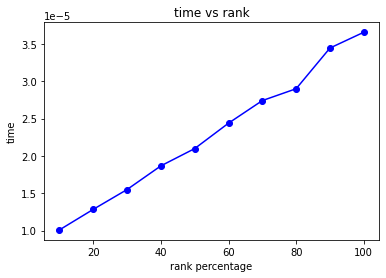

In [ ]:
# TODO: add code to plot the relationship between time vs percentage rank of the matrix.

times = [t for _, t in ranks_and_times]
rank_percentage = np.arange(1.0, 0.0, -0.1)*100

plt.title('time vs rank')
plt.xlabel("rank percentage" )
plt.ylabel("time")

plt.plot(rank_percentage, times, 'bo-');

### Q7: What do you observe between time and the percentage rank of the matrix.

### Put your answer here:


<font color=#f5072f>
In the figure, the increasing inference time and the increasing rank percentage show a very strong positive and almost symmetric linear relationship. In other words, the higher rank approximation requires more inference time and vice versa. Inference time spans scale from 0 to little bit above 6e-9 with step size 1e-9 and rank percentage spans scale from 0 to 100 with step size 20. The relationship between two variables is established by 10 points.
</ font>

## Coding Challenge Part 4: Take this Further (10 bonus points)

This part of the challenge is designed to be open ended. If you wanted to show some more skills, here is your chance to shine. We include two options below -- **only do one of the options**:

**Option 1:** Implement a change that isn't SVD but minimizes inference latency while preserving accuracy. Can you outperform SVD? 



**Option 2:** Improve the quality of code for this takehome. Pretend you are reviewing a peer and add comments to cells with suggestions of how to improve the code quality. Try and make your comments action orientated and precise. 


**For Option 1, DO NOT alter the previous code sections, instead add any new code below. You should not need to add new code for Option 2, instead just add comments to cells.**


A. here starts the layer removal implementation

In [ ]:
# TODO: add code for option 1 here

### please note that this code uses data loaded in in previous home works, some reusable functions and results of svd for comparison

### before going in advanced compression techniques, probably the simplest way of reducing models size would be
### chopping of the obviously unnecessary huge stack of 3 or 4 unnecessary  layers: linear 0, 1, 2 and 3.
### stacking of many linear layers with relu is unnecessary because is very simple dataset and conv layers do most important job for image understanding.
### additionally even leaving only one of the two conv layers could still give a not very bad performance
### So, first I will try compression just by removing 4 or 3 linear layers. I will also try to implement second type of compression later. 

### So, here will be two versions of compression: 
### A. removal of model layers 
### B. if time's left, I'll also try to implement pruning based on deepmind example
### of course we also could chain, first apply A. than B. but I just want to compare them, so I won't chain them


### A. compression by removal of whole layers 
       ## there are two choices: 
       ## 1. define that smaller model and just copy-paste code of training from homework 1 to train model from scratch
       ## 2. use already trained model, chop of last layers like while finetuning and retrain with frozen then unfroze parameters
       ## first is very obvious how to do, but in real life second may be more useful let's do it. have no idea how to implement in jax though

### A.
# define a smaller model without many linear layers and take weights and biases only for remaining layers from params of already trained model 

def smallnet_fn(batch: Batch) -> jnp.ndarray:
  x = normalize(batch[0])  

  smnet = hk.Sequential([
      hk.Conv2D(output_channels=6*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(output_channels=16*3, kernel_shape=(5,5)),
      jax.nn.relu,
      hk.AvgPool(window_shape=(2,2), strides=(2,2), padding='VALID'),
      hk.Flatten(),
      ## hk.Linear(3000), jax.nn.relu,
      ## hk.Linear(2000), jax.nn.relu,
      ## hk.Linear(2000), jax.nn.relu,
      ## hk.Linear(1000), jax.nn.relu,
      hk.Linear(10),
  ])
  return smnet(x)

smallnet = hk.without_apply_rng(hk.transform(smallnet_fn)) 
smallnet_params = smallnet_avg_params = smallnet.init(jax.random.PRNGKey(42), next(train))

for layer in params.keys():
  if 'conv' in layer:
    smallnet_params[layer]['w'] = params[layer]['w']
    smallnet_params[layer]['b'] = params[layer]['b']
  else: continue

### test with this:
# def parameter_shapes(params):
#   return jax.tree_util.tree_map(lambda p: p.shape, params)
# parameter_shapes(smallnet_params), smallnet_params.keys() #,smallnet_params #jax.tree_util.tree_structure(smallnet_params)


# got help from the haiku documentation https://dm-haiku.readthedocs.io/en/latest/notebooks/non_trainable.html
non_trainable_params, trainable_params = hk.data_structures.partition(
    lambda m, n, p: m != "linear", smallnet_params)    # generally it would be like "jax_module/mlp/~/linear"

print("trainable:", list(trainable_params))
print("non_trainable:", list(non_trainable_params))


/usr/local/lib/python3.7/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


trainable: ['linear']
non_trainable: ['conv2_d', 'conv2_d_1']


In [ ]:
### A.

# here i implement a slightly modeified training with freezed layers except the last one (we also could train the whole model)
# got help from the haiku documentation https://dm-haiku.readthedocs.io/en/latest/notebooks/non_trainable.html


# we need different approaches for untrained and trained parameters though for loss calculation we need to join them so we have to reimplement loss and forward
# loss from scratch, because our update function directly calls loss calculator and we cannot decouple them here

def loss_fn(trainable_params, non_trainable_params, batch):
  # we need to combine trainable and non trainable before calling apply.
  merged_params = hk.data_structures.merge(non_trainable_params, trainable_params)
  # same as before
  logits = smallnet.apply(merged_params, batch)   #None in between is not needed because we applied without rng key
  images, labels = batch
  labels = jax.nn.one_hot(labels, logits.shape[-1])
  softmax_xent =  -jnp.sum(labels * jax.nn.log_softmax(logits)) / labels.shape[0]
  l2_loss = sum([jnp.sum( jnp.vdot(w, w)) for i, w in enumerate(jax.tree_util.tree_leaves(trainable_params)) if i/2!=0])    
  weighted_l2_loss =  0.5 * l2_loss                    
  return softmax_xent + (1e-4 * weighted_l2_loss) 


def sgd_step(parameters, grads, *, lr):
  return jax.tree_util.tree_map(lambda p, g: p - g * lr, parameters, grads)  

@jax.jit
def smallnet_update(
    trainable_params: hk.Params,
    non_trainable_params: hk.Params,
    batch: Batch,
) -> Tuple[hk.Params, optax.OptState]:

  trainable_params_grads = jax.grad(loss_fn)(trainable_params, non_trainable_params, batch)
  trainable_params = sgd_step(trainable_params, trainable_params_grads, lr=0.1)
  return trainable_params

@jax.jit
def smallnet_ema_update(smallnet_params, smallnet_avg_params):
  return optax.incremental_update(smallnet_params, smallnet_avg_params, step_size=0.001) 

@jax.jit
def smallnet_accuracy(smallnet_params: hk.Params, batch: Batch) -> jnp.ndarray:
  predictions = smallnet.apply(smallnet_params, batch)
  _, lables = batch
  right_guesses = jnp.argmax(predictions, axis=1)==lables 
  accuracy = jnp.count_nonzero(right_guesses) / len(lables)
  return accuracy  


for step in range(10001): 
  if step % 100 == 0:   
    train_accuracy = smallnet_accuracy(smallnet_params, next(train))
    val_accuracy = smallnet_accuracy(smallnet_params, next(validation))
    test_accuracy = smallnet_accuracy(smallnet_avg_params, next(test))  
   
    train_accuracy, val_accuracy, test_accuracy = jax.device_get(
        (train_accuracy, val_accuracy, test_accuracy))
    print(f"[Step {step}] Train / Validation / Test accuracy: "
          f"{train_accuracy:.3f} / {val_accuracy:.3f} / {test_accuracy:.3f}.")

  trainable_params = smallnet_update(trainable_params, non_trainable_params, next(train))
  smallnet_params = hk.data_structures.merge(non_trainable_params, trainable_params)
  smallnet_avg_params = smallnet_ema_update(smallnet_params, smallnet_avg_params)


## one last time combine trainable and untrainable params
smallnet_params = hk.data_structures.merge(non_trainable_params, trainable_params)


[Step 0] Train / Validation / Test accuracy: 0.062 / 0.172 / 0.099.
[Step 100] Train / Validation / Test accuracy: 0.547 / 0.438 / 0.244.
[Step 200] Train / Validation / Test accuracy: 0.641 / 0.594 / 0.445.
[Step 300] Train / Validation / Test accuracy: 0.562 / 0.531 / 0.529.
[Step 400] Train / Validation / Test accuracy: 0.578 / 0.641 / 0.566.
[Step 500] Train / Validation / Test accuracy: 0.641 / 0.547 / 0.589.
[Step 600] Train / Validation / Test accuracy: 0.578 / 0.625 / 0.606.
[Step 700] Train / Validation / Test accuracy: 0.719 / 0.641 / 0.614.
[Step 800] Train / Validation / Test accuracy: 0.641 / 0.625 / 0.621.
[Step 900] Train / Validation / Test accuracy: 0.609 / 0.609 / 0.626.
[Step 1000] Train / Validation / Test accuracy: 0.609 / 0.609 / 0.631.
[Step 1100] Train / Validation / Test accuracy: 0.625 / 0.672 / 0.636.
[Step 1200] Train / Validation / Test accuracy: 0.641 / 0.719 / 0.640.
[Step 1300] Train / Validation / Test accuracy: 0.656 / 0.656 / 0.642.
[Step 1400] Train 

Accuracy: 0.68
Duration:  0.000006761654.



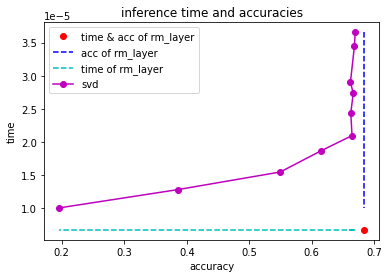

In [ ]:
### A.

### from the training results we see, that there is almost no change in validation or test accuracy
### still, let's check accuracy and inference time using same methods we used on svd based compression

batch = next(test)

def evaluate(smallnet_accuracy, smallnet_params, batch, n_samples):
  duration_list = []
  accuracy_list = []
  for _ in range(10):
    warm_up = smallnet_accuracy(smallnet_params, batch).block_until_ready()
  for _ in range(n_samples):
    start = time.time()  
    acc = smallnet_accuracy(smallnet_params, batch).block_until_ready()   
    ## !!! I am already deviding it on batch size here
    duration = (time.time() - start) / batch[0].shape[0]    
    duration_list.append(duration)
    accuracy_list.append(acc)
    # print(f"---------------\n" 
    #       f"Accuracy: {acc:.2f}\n" 
    #       f"Duration:  {duration:.12f}.")
  return accuracy_list, duration_list


accuracy_list, duration_list = evaluate(smallnet_accuracy=smallnet_accuracy, 
                                        smallnet_params=smallnet_params, 
                                        batch=batch, 
                                        n_samples=50)

### let's compare what can be compared with the results of svd compresion method
### comparison showes, that using layer removal we achieved as high accuracy as via highest rank svd compression,  
### but much smaller latency than lowest rank svd compresion

plt.title('inference time and accuracies')
plt.xlabel("accuracy")
plt.ylabel("time")

plt.plot(np.mean(accuracy_list), np.mean(duration_list), 'ro')
plt.plot(np.repeat(np.mean(accuracy_list), len(accuracies)), times, 'b--');
plt.plot(accuracies, np.repeat(np.mean(duration_list), len(times)), 'c--');
plt.plot(accuracies, times, 'mo-');
plt.legend(['time & acc of rm_layer', 'acc of rm_layer', 'time of rm_layer', 'svd']);

print(f"Accuracy: {np.mean(accuracy_list):.2f}\n" f"Duration:  {np.mean(duration_list):.12f}.\n")

B. here starts the pruning implementation

In [ ]:
### B. compression by prunning

#### I learned how to do pruning from deepmind example and the refered paper in that example. I also followed the example code there. 
#### R E F E R E N C E:
#### haiku example for pruning here: https://github.com/deepmind/dm-haiku/blob/main/examples/mnist_pruning.py

#### if in section A. we removed whole layers, used conv layers parameters and updated weight only for last newly added layer
#### in section B. we apply masks for whole network parameter making during forward and backward pass and update masked parameters
#### we gradually decrease used parameters (make mask more sparse) according to algorithm for automated gradual pruning schedule
#### performance at different levels of sparsity like we did it with different svd ranks.

from typing import Callable, Sequence

Predicate = Callable[[str, str, jnp.ndarray], bool]
PredicateMap = Mapping[Predicate, jnp.ndarray]
ModuleSparsity = Sequence[Tuple[Predicate, jnp.ndarray]]


def topk_mask(value: jnp.ndarray, density_fraction: float) -> jnp.ndarray:
 
  def topk_mask_internal(value):
    assert value.ndim == 1
    indices = jnp.argsort(value)
    k = jnp.round(density_fraction * jnp.size(value)).astype(jnp.int32)
    mask = jnp.greater_equal(np.arange(value.size), value.size - k)
    #because jnp creates imutable array, even if we would not do this, still would get an array just with new memory loc
    mask = jnp.zeros_like(mask).at[indices].set(mask) 
    #generally float,int in jax is max 32, so 64 anyway will get converted down to 32
    return mask.astype(np.int32)    

  # shuffle value so that identical values aren't always pruned
  # with a bias to lower indices
  orig_shape = value.shape
  value = jnp.reshape(value, -1)
  
  ##### jax.random.shuffle is deprecated, one solution for the future use here: https://github.com/google/jax/discussions/8429
  shuffled_indices = jax.random.shuffle(
      jax.random.PRNGKey(42), jnp.arange(0, jnp.size(value), dtype=jnp.int32))


  shuffled_mask = topk_mask_internal(value[shuffled_indices])
  mask = jnp.zeros_like(shuffled_mask).at[shuffled_indices].set(shuffled_mask)
  mask = jnp.reshape(mask, orig_shape)
  return mask

## from the same paper: https://ar5iv.labs.arxiv.org/html/1710.01878 or pdf: https://arxiv.org/pdf/1710.01878.pdf
## important take away 1: paper introduces algorithm for automated gradual pruning schedule
## important take away 2: pruning schedule must be close to lr schedule
## as we take initial sparsity s_i=0 and final sparsity s_f=1 we have the following implementation:
def zhugupta_func(progress: jnp.ndarray) -> jnp.ndarray:
  """1. decides 'To Prune or Not To Prune' 
     2. applies automated pruning schedule 
        by determining pruning values for each new pruning step
        :cite:`zhu2017prune`."""
  return 1. - (1. - progress)**3


def _create_partitions(
    module_sparsity: ModuleSparsity, params: hk.Params
) -> Tuple[Sequence[hk.Params], Sequence[jnp.ndarray], hk.Params]:

  list_of_trees = []
  sparsity_list = []

  tail = params
  # Greedily match so that no parameter can be matched more than once
  for predicate, sparsity in module_sparsity:
    head, tail = hk.data_structures.partition(predicate, tail)
    list_of_trees.append(head)
    sparsity_list.append(sparsity)

  return list_of_trees, sparsity_list, tail ## list to be pruned, list of pruning levels, list that will not be pruned


def sparsity_ignore(m: str, n: str, v: jnp.ndarray) -> bool:
  """ conditions when pruning should not happen"""
  # n == 'b' when param is a bias
  return n == "b" or v.ndim == 1 or "batchnorm" in m or "batch_norm" in m


@partial(jax.jit, static_argnums=2)
def apply_mask(params: hk.Params, masks: Sequence[hk.Params],
               module_sparsity: ModuleSparsity) -> hk.Params:   
  # module_sparsity tuples predicates and corresponding sparsity levels 
  params_to_prune, _, params_no_prune = _create_partitions(
      module_sparsity, params) 
  pruned_params = []
  for value, mask in zip(params_to_prune, masks):
    pruned_params.append(
        jax.tree_util.tree_map(lambda x, y: x * y, value, mask))
  params = hk.data_structures.merge(*pruned_params, params_no_prune)
  return params


@partial(jax.jit, static_argnums=2) 
def update_mask(params: hk.Params, sparsity_fraction: float,
                module_sparsity: ModuleSparsity) -> Sequence[hk.Params]:
  """Generate masks based on module_sparsity and sparsity_fraction."""
  params_to_prune, sparsities, _ = _create_partitions(module_sparsity, params)
  masks = []

  def map_fn(x: jnp.ndarray, sparsity: float) -> jnp.ndarray:
    return topk_mask(jnp.abs(x), 1. - sparsity * sparsity_fraction)

  for tree, sparsity in zip(params_to_prune, sparsities):
    #we imported partial from functools: functools.partial
    map_fn_sparsity = partial(map_fn, sparsity=sparsity) 
    mask = jax.tree_util.tree_map(map_fn_sparsity, tree)
    masks.append(mask)
  return masks


@jax.jit
def get_sparsity(params: hk.Params):
  """Calculate the number of all params, the total sparsity and tensor-wise sparsity of params."""
  total_params = sum(jnp.size(x) for x in jax.tree_util.tree_leaves(params))
  total_nnz = sum(jnp.sum(x != 0.) for x in jax.tree_util.tree_leaves(params))
  leaf_sparsity = jax.tree_util.tree_map(
      lambda x: jnp.sum(x == 0) / jnp.size(x), params)
  return total_params, total_nnz, leaf_sparsity


# Define layerwise sparsities
def module_matching(s):

  def match_func(m, n, k):
    return m.endswith(s) and not sparsity_ignore(m, n, k)

  return match_func


## initial sparsity is mostly no sparsity (0) which corresponds to 1 here. 
## see update_mask function: e.g. (1. - 0.98 * sparsity_fraction) for linear_1
## so, the smaller values here mean more resistance to pruning
module_sparsity = ((module_matching("conv2_d"), 0.98),
                   (module_matching("conv2_d_1"), 0.98),
                   (module_matching("linear"), 0.98),   
                   (module_matching("linear_1"), 0.98),
                   (module_matching("linear_2"), 0.98),
                   (module_matching("linear_3"), 0.98),
                   (module_matching("linear_4"), 0.98))

### of course module_sparsity should correspond to net_fn for quick lookup use this, or scroll up to net_fn
# def parameter_shapes(params):
#   return jax.tree_util.tree_map(lambda p: p.shape, params)
#parameter_shapes(params)

In [ ]:
### B.

#### jax.numpy.save('./params.npy', params) #jax.numpy.savez('./params.npz', params) 
#### par = jax.numpy.load('./params.npy', allow_pickle=True) #generally avoid allow_pickle=True it has vulnerabilities
#### check documentation on that https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.load.html

### these two lines are here to prevent jax from using already jited version 'lasely' that breakes the code
net = hk.without_apply_rng(hk.transform(net_fn)) 
model_params = prune_avg_params = net.init(jax.random.PRNGKey(42), next(train))

params_pruned = model_params = prune_avg_params = deepcopy(params)

masks = update_mask(model_params, 0., module_sparsity)
prune_opt = optax.adam(1e-3)
prune_opt_state = prune_opt.init(model_params)


@jax.jit
def get_updates(
    params: hk.Params,
    opt_state: optax.OptState,
    batch: Batch,
) -> Tuple[hk.Params, optax.OptState]:
  """Learning rule (stochastic gradient descent)."""
  grads = jax.grad(compute_loss)(params, batch)          # I reuse loss and accuracy functions from first coding task 
  updates, opt_state = opt.update(grads, opt_state)
  ## we do not apply updates here
  ## so, we ommit new_params = optax.apply_updates(someparams, someupdates) as we do this in a training loop separately
  return updates, opt_state

pruning_states = []
prune_lvl = 0

for step in range(10001):
    # evaluate classification accuracy on train & test sets by using current masked parameters (at given stage of prunning)   
    if step % 1000 == 0:
      
      prune_avg_params = apply_mask(prune_avg_params, masks, module_sparsity)
      
      train_accuracy = compute_accuracy(prune_avg_params, next(train))
      test_accuracy = compute_accuracy(prune_avg_params, next(test))

      total_params, total_nnz, per_layer_sparsities = get_sparsity(prune_avg_params)
      total_sparsity = 1. - total_nnz / total_params
      
      train_accuracy, test_accuracy, total_nnz, per_layer_sparsities = (
          jax.device_get(
              (train_accuracy, test_accuracy, total_nnz, per_layer_sparsities)))
      print(f"[Step {step}] Train / Test accuracy: "
            f"{train_accuracy:.3f} / {test_accuracy:.3f}.")
      print(f"Non-zero params / Total: {total_nnz} / {total_params}; "
            f"Total Sparsity: {total_sparsity:.3f}")
      
      
    if prune_lvl<(total_sparsity*10) or (total_sparsity==0.98): 
      ## 0.98 because pruning was set not to reach 1 but around 0.98
      pruning_states.append((model_params, total_sparsity*100))
      prune_lvl+=1

    # Do SGD on a batch of training examples.
    params_pruned = apply_mask(model_params, masks, module_sparsity)
    updates, prune_opt_state = get_updates(params_pruned, prune_opt_state, next(train))
    # before applying updates on parameters we use mask to expose only those parameters we want to apply updates on
    updates = apply_mask(updates, masks, module_sparsity)
    model_params = optax.apply_updates(model_params, updates)
    
    # start pruning at iteration t_zero = 1000 and end at iteration 8000
    # as the params are already trained we also could start pruning earlier at t_zero = 0
    # this part is only filling the main automated gradual pruning algorithm that is implemented in zhugupta_func above
    progress = min(max((step - 1000.) / 8000., 0.), 1.)  
    #so, 0=<progress=<1, n span of pruning steps: (8000-1000) and pruning frequency delta_t: (1/200) 
    if step % 200 == 0:
      sparsity_fraction = zhugupta_func(progress)
      masks = update_mask(model_params, sparsity_fraction, module_sparsity)
    
    prune_avg_params = ema_update(model_params, prune_avg_params)
print(per_layer_sparsities)

### let's calculate accuracies and inference times as we did for svd
batch = next(test)
prune_accuracies, prune_durations, prune_levels = [], [], []

for sparse_model_params, sparsity_level in pruning_states:
  prune_accuracy_list, prune_duration_list = evaluate(compute_accuracy, sparse_model_params, batch, 50)
  ### evaluate function internally devides times on batch size
  
  prune_accuracies.append(np.mean(prune_accuracy_list))
  prune_durations.append(np.mean(prune_duration_list))
  prune_levels.append(sparsity_level)

/usr/local/lib/python3.7/dist-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)
/usr/local/lib/python3.7/dist-packages/jax/_src/random.py:399: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


[Step 0] Train / Test accuracy: 0.781 / 0.669.
Non-zero params / Total: 30416239 / 30462226; Total Sparsity: 0.002
[Step 1000] Train / Test accuracy: 0.859 / 0.698.
Non-zero params / Total: 30460849 / 30462226; Total Sparsity: 0.000
[Step 2000] Train / Test accuracy: 0.891 / 0.700.
Non-zero params / Total: 22374212 / 30462226; Total Sparsity: 0.266
[Step 3000] Train / Test accuracy: 0.875 / 0.694.
Non-zero params / Total: 14509572 / 30462226; Total Sparsity: 0.524
[Step 4000] Train / Test accuracy: 0.828 / 0.646.
Non-zero params / Total: 8813360 / 30462226; Total Sparsity: 0.711
[Step 5000] Train / Test accuracy: 0.828 / 0.605.
Non-zero params / Total: 4935833 / 30462226; Total Sparsity: 0.838
[Step 6000] Train / Test accuracy: 0.656 / 0.525.
Non-zero params / Total: 2527243 / 30462226; Total Sparsity: 0.917
[Step 7000] Train / Test accuracy: 0.609 / 0.514.
Non-zero params / Total: 1237845 / 30462226; Total Sparsity: 0.959
[Step 8000] Train / Test accuracy: 0.547 / 0.471.
Non-zero para

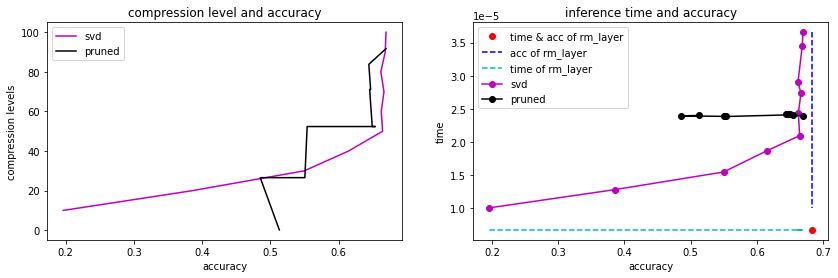

In [ ]:
#### B.

### let's compare svd, layer removal, and pruning results

figure, axis = plt.subplots(1, 2)
figure.set_size_inches(14, 4)

axis[0].set_title("compression level and accuracy")
axis[0].set_xlabel("accuracy")
axis[0].set_ylabel("compression levels")
axis[0].plot(accuracies, rank_percentage, 'm-')
axis[0].plot(prune_accuracies[::-1], prune_levels, 'k-')
axis[0].legend(['svd', 'pruned'])

axis[1].set_title('inference time and accuracy')
axis[1].set_xlabel("accuracy")
axis[1].set_ylabel("time")
axis[1].plot(np.mean(accuracy_list), np.mean(duration_list), 'ro')
axis[1].plot(np.repeat(np.mean(accuracy_list), len(accuracies)), times, 'b--')
axis[1].plot(accuracies, np.repeat(np.mean(duration_list), len(times)), 'c--')
axis[1].plot(accuracies, times, 'mo-')
axis[1].plot(prune_accuracies[::-1], prune_durations[::-1], 'ko-')
axis[1].legend(['time & acc of rm_layer', 'acc of rm_layer', 'time of rm_layer', 'svd', 'pruned'])

plt.show()

What results may indicate for our toy example:

Pruning
1. **inference time:** pruning results are not much sensitive to inference time, so pruning level (here also refered as compression level / pruning percentage) doesn't give much different inference times for different compression levels (see right figure).
2. **accuracy:** both figures show, that pruning appeares still quite robust to accuracy drop especially when we reach very high levels of sparcity, which may be the gain for "compression".

SVD

schoves positive dependece in both cases compression level vs accuracy, and inference time vs accuracy (see both figures). One nice characteristic of svd here is, that to some point reasonably high compression does not affect the accuracy too mutch (left figure) and at the same time each level of those compressions greatly decreases inference time (right figure). 

Layer removal

almost fully retained accuracy of original model (function) and at the same time greately decreased inference time. In both metrics it outperformed best variants fo pruning and svd.

Lastly we can also chain all these model compressions in different ways.